## Importation des bibliothèques

In [ ]:
import pandas as pd
import re
import ipaddress
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from urllib.parse import urlparse


Importation des bibliothèques nécessaires pour le projet.

## Chargement et préparation des données

Chargement et visualisation des données initiales.

In [ ]:
df=pd.read_csv("malicious_phish.csv")

In [ ]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
df.columns

Index(['url', 'type'], dtype='object')

In [ ]:
df['type'].unique()

array(['phishing', 'benign', 'defacement', 'malware', nan], dtype=object)

Comptage de nombre des URL ayant un type null

In [ ]:
nan_count = df['type'].isna().sum()
nan_count

1

Suppression des valeurs manquantes

In [ ]:
df = df.dropna(subset=['type'])

Indexation de la colonne type en fonction des labes des URL

- URL legitime: type 0
- URL suspect(phishing, malware...): type 1


In [ ]:
# Create 'label' column based on the condition
df['type'] = df['type'].apply(lambda x: 0 if x == 'benign' else 1)

<ipython-input-8-b251bbc0fa2e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].apply(lambda x: 0 if x == 'benign' else 1)


## Création des variables explicatives

Préparation de fonctions utiles pour l'extraction de "features" qui représentent nos variables explicatives et qui auront le rôle de données d'entrainement pour notre algorithme de classification.

In [ ]:


# Function to extract domain from URL
def getDomain(url):
    domain = urlparse(url).netloc
    if re.match(r"^www\.", domain):
        domain = domain.replace("www.", "")
    return domain

# Check if URL contains an IP address
def havingIP(url):
    try:
        ipaddress.ip_address(url)
        return 1
    except:
        return 0

# Check for "@" symbol in URL
def haveAtSign(url):
    return 1 if "@" in url else 0

# Get URL length
def getLength(url):
    return len(url)

# Get URL depth (number of '/' in path)
def getDepth(url):
    path = urlparse(url).path
    return path.count('/')

# Check if URL uses HTTPS
def useOfHTTPS(url):
    return 1 if urlparse(url).scheme == 'https' else 0

# Check if URL is shortened
def isShortened(url):
    shorteners = ["bit.ly", "goo.gl", "tinyurl", "ow.ly", "is.gd", "t.co"]
    domain = getDomain(url)
    return 1 if domain in shorteners else 0

# Count subdomains
def countSubdomains(url):
    domain = getDomain(url)
    return domain.count('.')

# Check for suspicious characters like '-' and '_'
def containsSuspiciousCharacters(url):
    return 1 if "-" in url or "_" in url else 0

# Length of the domain name
def domainLength(url):
    domain = getDomain(url)
    return len(domain)

# Count digits in the URL
def digitCount(url):
    return sum(c.isdigit() for c in url)

# Check if URL contains sensitive words
def containsSensitiveWords(url):
    sensitive_words = ["login", "secure", "account", "update", "bank", "verify"]
    return 1 if any(word in url for word in sensitive_words) else 0

# Check if URL contains encoded characters
def usesURLEncoding(url):
    return 1 if '%' in url else 0

# Check if the TLD is suspicious
def isSuspiciousTLD(url):
    suspicious_tlds = ["xyz", "top", "club", "online", "info"]
    tld = getTopLevelDomain(url)
    return 1 if tld in suspicious_tlds else 0

# Get top-level domain (TLD) from URL
def getTopLevelDomain(url):
    domain = getDomain(url)
    return domain.split('.')[-1]

# Check if "https" is in the domain name
def httpsInDomain(url):
    domain = getDomain(url)
    return 1 if 'https' in domain else 0

# Check if URL has a redirect "//" in the path
def hasRedirect(url):
    return 1 if "//" in urlparse(url).path else 0

# Get URL path length
def getPathLength(url):
    path = urlparse(url).path
    return len(path)


## Extraction des features des URLs du jeu de données

In [ ]:
def featureExtraction(url, label):
    features = []
    # Address bar-based features
    features.append(getDomain(url))                  # Domain name
    features.append(havingIP(url))                   # IP in URL
    features.append(haveAtSign(url))                 # '@' symbol
    features.append(getLength(url))                  # URL length
    features.append(getDepth(url))                   # Depth of URL
    features.append(useOfHTTPS(url))                 # HTTPS protocol
    features.append(isShortened(url))                # URL shortener check
    features.append(countSubdomains(url))            # Subdomain count
    features.append(containsSuspiciousCharacters(url))  # Suspicious characters in URL
    features.append(domainLength(url))               # Domain length
    features.append(digitCount(url))                 # Number of digits in URL
    features.append(containsSensitiveWords(url))     # Sensitive words in URL
    features.append(usesURLEncoding(url))            # URL encoding presence
    features.append(isSuspiciousTLD(url))            # Suspicious TLD
    features.append(httpsInDomain(url))              # "https" in domain
    features.append(hasRedirect(url))                # Redirection in URL
    features.append(getPathLength(url))              # Path length

    # Include the label as the last feature
    features.append(label)

    return features


Application de l'extraction de features sur tous les URLs de notre dataset initial.

In [ ]:
#Extracting the feautres & storing them in a list
features = []
for i in range(len(df)):
    url = df['url'][i]
    label = df['type'][i]
    features.append(featureExtraction(url, label))

**Résultat :** Création du dataframe nécessaire pour l'entrainement du modèle.

In [ ]:


#converting the list to dataframe
feature_names = [
    'Domain',               # getDomain(url)
    'Have_IP',              # havingIP(url)
    'Have_At',              # haveAtSign(url)
    'URL_Length',           # getLength(url)
    'URL_Depth',            # getDepth(url)
    'Use_of_HTTPS',         # useOfHTTPS(url)
    'TinyURL',              # isShortened(url)
    'Subdomain_Count',      # countSubdomains(url)
    'Suspicious_Characters',# containsSuspiciousCharacters(url)
    'Domain_Length',        # domainLength(url)
    'Digit_Count',          # digitCount(url)
    'Sensitive_Words',      # containsSensitiveWords(url)
    'URL_Encoding',         # usesURLEncoding(url)
    'Suspicious_TLD',       # isSuspiciousTLD(url)
    'HTTPS_in_Domain',      # httpsInDomain(url)
    'Redirection',          # hasRedirect(url)
    'Path_Length',          # getPathLength(url)
    'Label'                 # label
]


full_features_df = pd.DataFrame(features, columns=feature_names)
full_features_df.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Use_of_HTTPS,TinyURL,Subdomain_Count,Suspicious_Characters,Domain_Length,Digit_Count,Sensitive_Words,URL_Encoding,Suspicious_TLD,HTTPS_in_Domain,Redirection,Path_Length,Label
0,,0,0,16,0,0,0,0,1,0,0,0,0,0,0,0,16,1
1,,0,0,35,2,0,0,0,1,0,1,0,0,0,0,0,35,0
2,,0,0,31,3,0,0,0,0,0,1,0,0,0,0,0,31,0
3,garage-pirenne.be,0,0,88,1,0,0,1,1,17,7,0,0,0,0,0,10,1
4,adventure-nicaragua.net,0,0,235,1,0,0,1,1,23,22,0,0,0,0,0,10,1


In [ ]:
# Storing the data in CSV file
full_features_df.to_csv('urldata.csv', index=False)

## Lecture et exploration des données d'entrainement de l'algorithme Naive Bayes


In [ ]:
# Read the CSV file
data = pd.read_csv('urldata.csv')

data.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Use_of_HTTPS,TinyURL,Subdomain_Count,Suspicious_Characters,Domain_Length,Digit_Count,Sensitive_Words,URL_Encoding,Suspicious_TLD,HTTPS_in_Domain,Redirection,Path_Length,Label
0,NaN,0,0,16,0,0,0,0,1,0,0,0,0,0,0,0,16,1
1,NaN,0,0,35,2,0,0,0,1,0,1,0,0,0,0,0,35,0
2,NaN,0,0,31,3,0,0,0,0,0,1,0,0,0,0,0,31,0
3,garage-pirenne.be,0,0,88,1,0,0,1,1,17,7,0,0,0,0,0,10,1
4,adventure-nicaragua.net,0,0,235,1,0,0,1,1,23,22,0,0,0,0,0,10,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90647 entries, 0 to 90646
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Domain                 26479 non-null  object
 1   Have_IP                90647 non-null  int64 
 2   Have_At                90647 non-null  int64 
 3   URL_Length             90647 non-null  int64 
 4   URL_Depth              90647 non-null  int64 
 5   Use_of_HTTPS           90647 non-null  int64 
 6   TinyURL                90647 non-null  int64 
 7   Subdomain_Count        90647 non-null  int64 
 8   Suspicious_Characters  90647 non-null  int64 
 9   Domain_Length          90647 non-null  int64 
 10  Digit_Count            90647 non-null  int64 
 11  Sensitive_Words        90647 non-null  int64 
 12  URL_Encoding           90647 non-null  int64 
 13  Suspicious_TLD         90647 non-null  int64 
 14  HTTPS_in_Domain        90647 non-null  int64 
 15  Redirection        

In [ ]:
#Dropping the Domain column
data1 = data.drop(['Domain'], axis = 1).copy()

In [ ]:
data1.isnull().sum()

,0
Have_IP,0
Have_At,0
URL_Length,0
URL_Depth,0
Use_of_HTTPS,0
TinyURL,0
Subdomain_Count,0
Suspicious_Characters,0
Domain_Length,0
Digit_Count,0


In [ ]:
# shuffling the rows in the dataset so that when splitting the train and test set are equally distributed
data1 = data1.sample(frac=1).reset_index(drop=True)
data1.head()

,Have_IP,Have_At,URL_Length,URL_Depth,Use_of_HTTPS,TinyURL,Subdomain_Count,Suspicious_Characters,Domain_Length,Digit_Count,Sensitive_Words,URL_Encoding,Suspicious_TLD,HTTPS_in_Domain,Redirection,Path_Length,Label
0,0,0,89,5,0,0,1,1,15,22,1,0,0,0,0,63,1
1,0,0,72,2,0,0,1,0,9,24,0,1,1,0,0,56,1
2,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,17,1
3,0,0,23,1,0,0,0,0,0,0,0,0,0,0,0,23,0
4,0,0,35,2,0,0,0,0,0,0,0,0,0,0,0,35,0


In [ ]:
# Sepratating & assigning features and target columns to X & y
y = data1['Label']
X = data1.drop('Label',axis=1)
X.shape, y.shape

((90647, 16), (90647,))

## Division du jeu de données en données d'entrainement et données de test.

In [ ]:
# Splitting the dataset into train and test sets: 80-20 split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, random_state = 12)
X_train.shape, X_test.shape

((72517, 16), (18130, 16))

## Initialisation entrainement et test du modèle Naive Bayes.

In [ ]:


# Initialize the Naive Bayes classifier
nb_model = GaussianNB()

# Train the model on the training data
nb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = nb_model.predict(X_test)


## Evaluation du modèle; métriques de performance

In [ ]:
# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.88996138996139
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     13367
           1       0.83      0.73      0.78      4763

    accuracy                           0.89     18130
   macro avg       0.87      0.84      0.85     18130
weighted avg       0.89      0.89      0.89     18130



Confusion Matrix:
[[12660   707]
 [ 1288  3475]]


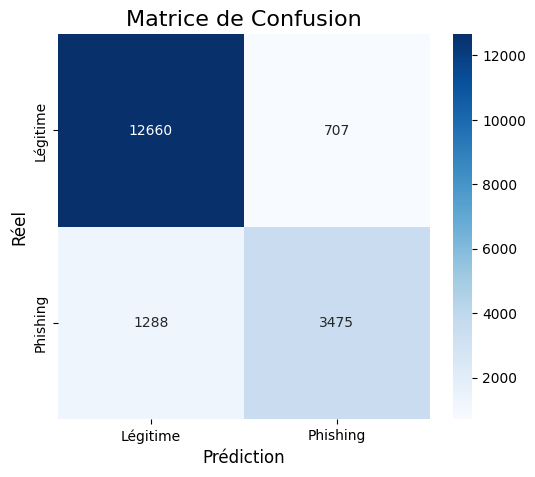

In [ ]:
from sklearn.metrics import confusion_matrix

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
import matplotlib.pyplot as plt
import seaborn as sns

# Affichage graphique de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Légitime', 'Phishing'], yticklabels=['Légitime', 'Phishing'])

# Titres et labels
plt.title("Matrice de Confusion", fontsize=16)
plt.xlabel("Prédiction", fontsize=12)
plt.ylabel("Réel", fontsize=12)
plt.show()

## Test sur des observations

In [ ]:
# Sample URLs for testing
test_urls = [
   "https://www.facebook.com/",
    "https://www.funzine.hu" ,
"https://chatgpt.com/",
"https://www.bulgariaski.com"  ,
"https://www.aoh61.com"  ,
      "https://www.southbankmosaics.com",
    "https://www.uni-mainz.de" ,
"https://www.rewildingaaaaaaaaargentina.org",
"http://www.teramill.com"  ,
"http://www.f051.9.1.41.xsph.ru",
   "https://www.f051.9.1.41.xsph.ru"

]


In [ ]:
# Prepare an empty list to store features of each test URL
test_features = []

# Extract features for each URL
for url in test_urls:
    features = featureExtraction(url, label=0)  # Label can be any value, we only care about the features here
    test_features.append(features[1:-1])        # Exclude the label in the test set


In [ ]:
test_features

[[0, 0, 25, 1, 1, 0, 1, 0, 12, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 22, 0, 1, 0, 1, 0, 10, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 20, 1, 1, 0, 1, 0, 11, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 27, 0, 1, 0, 1, 0, 15, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 21, 0, 1, 0, 1, 0, 9, 2, 0, 0, 0, 0, 0, 0],
 [0, 0, 32, 0, 1, 0, 1, 0, 20, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 24, 0, 1, 0, 1, 1, 12, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 42, 0, 1, 0, 1, 0, 30, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 23, 0, 0, 0, 1, 0, 12, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 30, 0, 0, 0, 5, 0, 19, 7, 0, 0, 0, 0, 0, 0],
 [0, 0, 31, 0, 1, 0, 5, 0, 19, 7, 0, 0, 0, 0, 0, 0]]

In [ ]:
# Encode only non-numeric columns
for col in X.columns:
    if X[col].dtype == 'object':
        label_encoder = LabelEncoder()
        X[col] = label_encoder.fit_transform(X[col])

In [ ]:

# Convert list of feature lists into a DataFrame
test_df = pd.DataFrame(test_features, columns=X.columns)
# Predict whether each URL is phishing (1) or legitimate (0)
predictions = nb_model.predict(test_df)

# Print the results
for url, prediction in zip(test_urls, predictions):
    result = "Legitimate" if prediction == 0 else "Phishing"
    print(f"URL: {url} - Prediction: {result}")


URL: https://www.facebook.com/ - Prediction: Legitimate
URL: https://www.funzine.hu - Prediction: Legitimate
URL: https://chatgpt.com/ - Prediction: Legitimate
URL: https://www.bulgariaski.com - Prediction: Legitimate
URL: https://www.aoh61.com - Prediction: Legitimate
URL: https://www.southbankmosaics.com - Prediction: Legitimate
URL: https://www.uni-mainz.de - Prediction: Legitimate
URL: https://www.rewildingaaaaaaaaargentina.org - Prediction: Legitimate
URL: http://www.teramill.com - Prediction: Phishing
URL: http://www.f051.9.1.41.xsph.ru - Prediction: Phishing
URL: https://www.f051.9.1.41.xsph.ru - Prediction: Legitimate
